In [10]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import h5py

# Loading data


In [11]:
patient_dir = Path('/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358')
h5_files = list((patient_dir / 'h5s').glob('*.h5'))
print(f'Found {len(h5_files)} h5 files')
print(f"The first file is {h5_files[0]}")

Found 1 h5 files
The first file is /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5


# Preprocessing data

In [ ]:
with h5py.File(h5_files[0], 'r') as f:
    for key in f.keys():
        print(f'Key: {key}')
    for attr in f.attrs:
        print(f'Attribute: {attr}')

    data = f['kspace'][()]
    print(f'\nShape: {data.shape}')
    print(f'Data type: {data.dtype}')

Key: ismrmrd_header
Key: kspace
Attribute: acq_mat_dcm_hdr
Attribute: acquisition
Attribute: cols_dcm_hdr
Attribute: do_norm_to_ref
Attribute: do_rm_zero_pad
Attribute: max
Attribute: max_phase_crop
Attribute: n_averages_dcm_hdr
Attribute: n_phase_enc_steps_dcm_hdr
Attribute: norm
Attribute: pat_pos_dcm_hdr
Attribute: patient_id
Attribute: patient_id_seq
Attribute: percent_phase_fov_dcm_hdr
Attribute: percent_sampling_dcm_hdr
Attribute: pixel_spacing_dcm_hdr
Attribute: rows_dcm_hdr
Shape: (3, 30, 20, 768, 651)
Data type: complex64


## check for zero-padding

/tmp/ipykernel_347915/2676694181.py:29: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(kspace[0, 0, 0, ...])), cmap='gray')


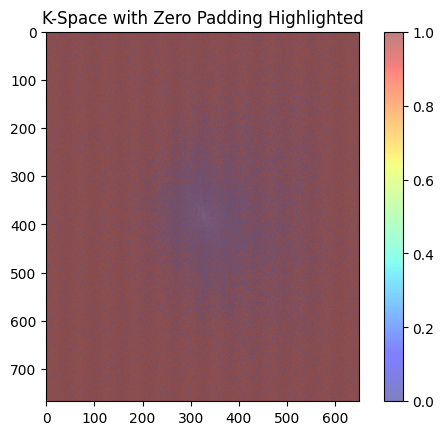

In [18]:
def check_zero_padding(kspace: np.ndarray, threshold: float = 1e-5) -> np.ndarray:
    """
    This function checks for zero-padding in the k-space data.
    It returns a boolean array indicating where zero-padding is present (near-zero values).
    
    Args:
    kspace (np.ndarray): The k-space data array.
    threshold (float): The threshold below which values are considered zero-padding.

    Returns:
    np.ndarray: A boolean array where True indicates zero-padding, False otherwise.
    """
    # Identify where the k-space values are below the threshold (indicating zero-padding)
    zero_padding_mask = np.abs(kspace) < threshold
    return zero_padding_mask

def plot_zero_padding(kspace: np.ndarray, threshold: float = 1e-5) -> None:
    """
    This function visualizes the k-space slice and highlights zero-padded regions.
    
    Args:
    kspace (np.ndarray): The k-space data array.
    threshold (float): The threshold below which values are considered zero-padding.
    """
    zero_padding_mask = check_zero_padding(kspace, threshold)
    
    # Plot the k-space with a mask overlay to show zero-padded areas
    plt.figure()
    plt.imshow(np.log(np.abs(kspace[0, 0, 0, ...])), cmap='gray')
    plt.imshow(zero_padding_mask[0, 0, 0, ...], cmap='jet', alpha=0.5)  # Overlay zero-padding
    plt.colorbar()
    plt.title('K-Space with Zero Padding Highlighted')
    plt.show()

# Example usage:
plot_zero_padding(data)


# Visualization Functions


In [ ]:
def plot_kspace(kspace: np.ndarray) -> None:
    plt.figure()
    # The techinical explanation is: kspace is a complex number, and the log of a complex number is a complex number, so we take the absolute value of the complex number to get a real number, and then we take the log of that real number.
    plt.imshow(np.log(np.abs(kspace[0, 0, 0, ...])), cmap='gray')
    plt.colorbar()
    plt.show()

/tmp/ipykernel_347915/3379916845.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(kspace[0, 0, 0, ...])), cmap='gray')


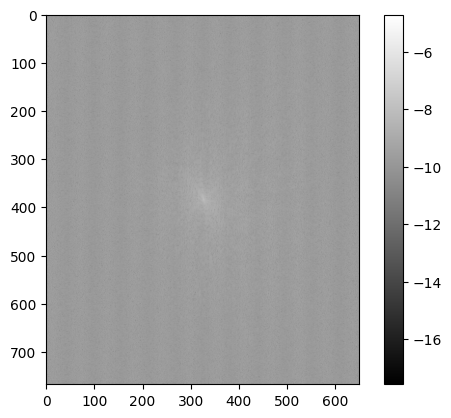

In [17]:
plot_kspace(data)